In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

In [3]:
api_key = "pCRLPdf2lkjpRX9Uczpt2gVBb" 
api_secret = "G1Wv7sTLMYF3cr5LbL8S9uj2g2LFrdWp8X8t7Ft3sIpW0kbqgD" 
access_token = "100875722-7m5vhOzpw2LYrB7P8ISnTqtGYMMvVTqwx3X4EyJY" 
access_token_secret = "uPEymGiszhiJEVWD4Alo1pzMUJx1ymo3Fd4HWyRPRBN3r" 

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["DataWranglingDay2"]["Harris"]
col.count()

<ipython-input-3-209640b1f787>:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  col.count()


10479

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=3000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        
        self.counter += 1
        
        
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
           
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Harris",""
           ]


progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)


for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Tweets collected: 0
Total tweets in collection: 10481


<ipython-input-4-ea33fae95756>:55: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  print("Total tweets in collection: %s" % col.count())


In [5]:
col.find_one()

{'_id': ObjectId('5f9ba2589adc09d695ef7e71'),
 'created_at': 'Fri Oct 30 05:19:15 +0000 2020',
 'id': 1322045379228164096,
 'id_str': '1322045379228164096',
 'text': 'RT @colinflaherty: Check the closest phone booth.',
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 2763687557,
  'id_str': '2763687557',
  'name': 'Erin Schmitt',
  'screen_name': 'erinschmitt66',
  'location': 'pittsburgh.pa usa',
  'url': None,
  'description': None,
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 2565,
  'friends_count': 3058,
  'listed_count': 103,
  'favourites_count': 45148,
  'statuses_count': 82533,
  'created_at': 'Sun Sep 07 04:17:24 +0000 2014',
  'utc_offset': None,
  'time_zone': None,
  'geo_enabl

In [6]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)


In [7]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,rt,7342
1,harris,6265
2,in,5094
3,the,4809
4,and,3846
5,to,3580
6,co,3306
7,https,3229
8,county,2781
9,biden,2555


<ipython-input-8-a8481ec67a37>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.source_name = dataset.source.apply(get_source_name)


Twibble.io               10
Tweetbot for iΟS         14
Mobile Web (M2)          16
dlvr.it                  18
TweetDeck                27
WordPress.com            28
Twitter for iPad        664
Twitter Web App        2614
Twitter for Android    2739
Twitter for iPhone     4205
Name: source, dtype: int64

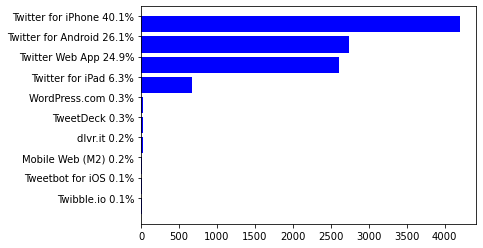

In [8]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

et       10
tl       11
in       21
ja       22
pt       26
eu       37
es       45
fr       47
und     832
en     9367
Name: lang, dtype: int64

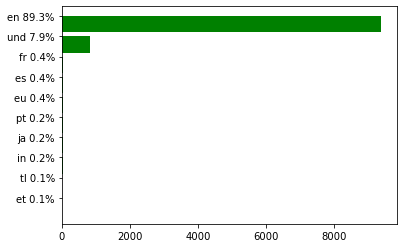

In [9]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [10]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from  textblob import TextBlob

In [11]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)

is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
0,1322045379228164096,RT @colinflaherty: Check the closest phone booth.,en
1,1322045379282526209,RT @HarrisVotes: It's time to EXPLORE THE SPAC...,en
2,1322045382285697024,RT @BetoORourke: MORE VOTING! https://t.co/HNQ...,en
3,1322045382906576897,RT @BetoORourke: 24-hour voting in Harris County:,en
4,1322045387943956481,RT @BetoORourke: 24-hour voting in Harris County:,en
...,...,...,...
10616,1322067321721114624,RT @northeast_mama: I put obituaries for my mo...,en
10617,1322067329916805122,RT @JoeBiden: Latinas are the heart of our com...,en
10618,1322067329916805122,RT @JoeBiden: Latinas are the heart of our com...,en
10619,1322067331779088384,"RT @SinghLions: Dear Joe Biden,\nMy family and...",en


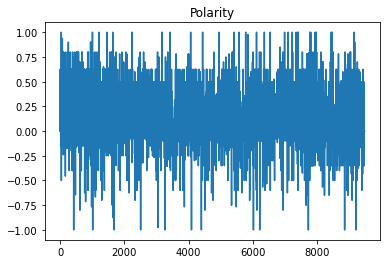

In [12]:
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

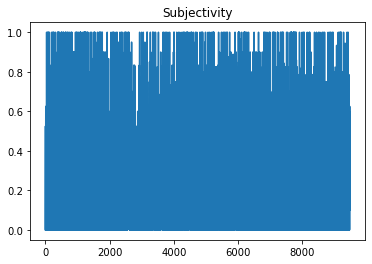

In [13]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [14]:
import statistics
statistics.mean(poltweet.polarity)

0.08078934916091292

In [15]:
import statistics
statistics.mean(poltweet.subjectivity)

0.3228085647016892

In [16]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [17]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100


a = dataset1['text'].str.lower().str.cat(sep=' ')


b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


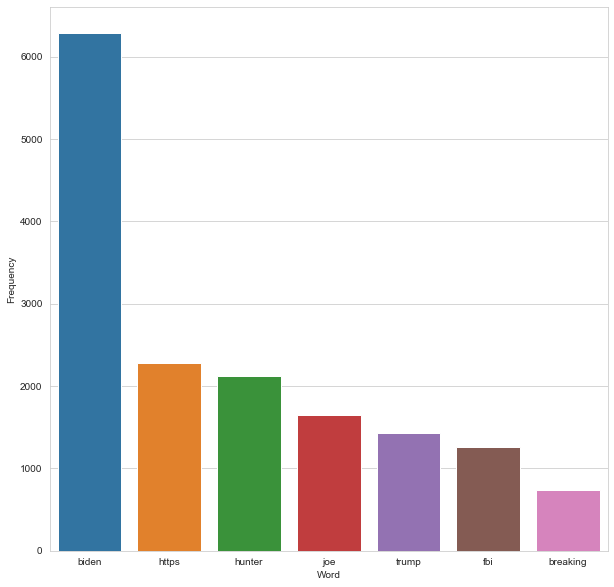

In [18]:
import seaborn as sns
 
without_single_chr = [word for word in filtered_sentence if len(word) > 2]


cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        


word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

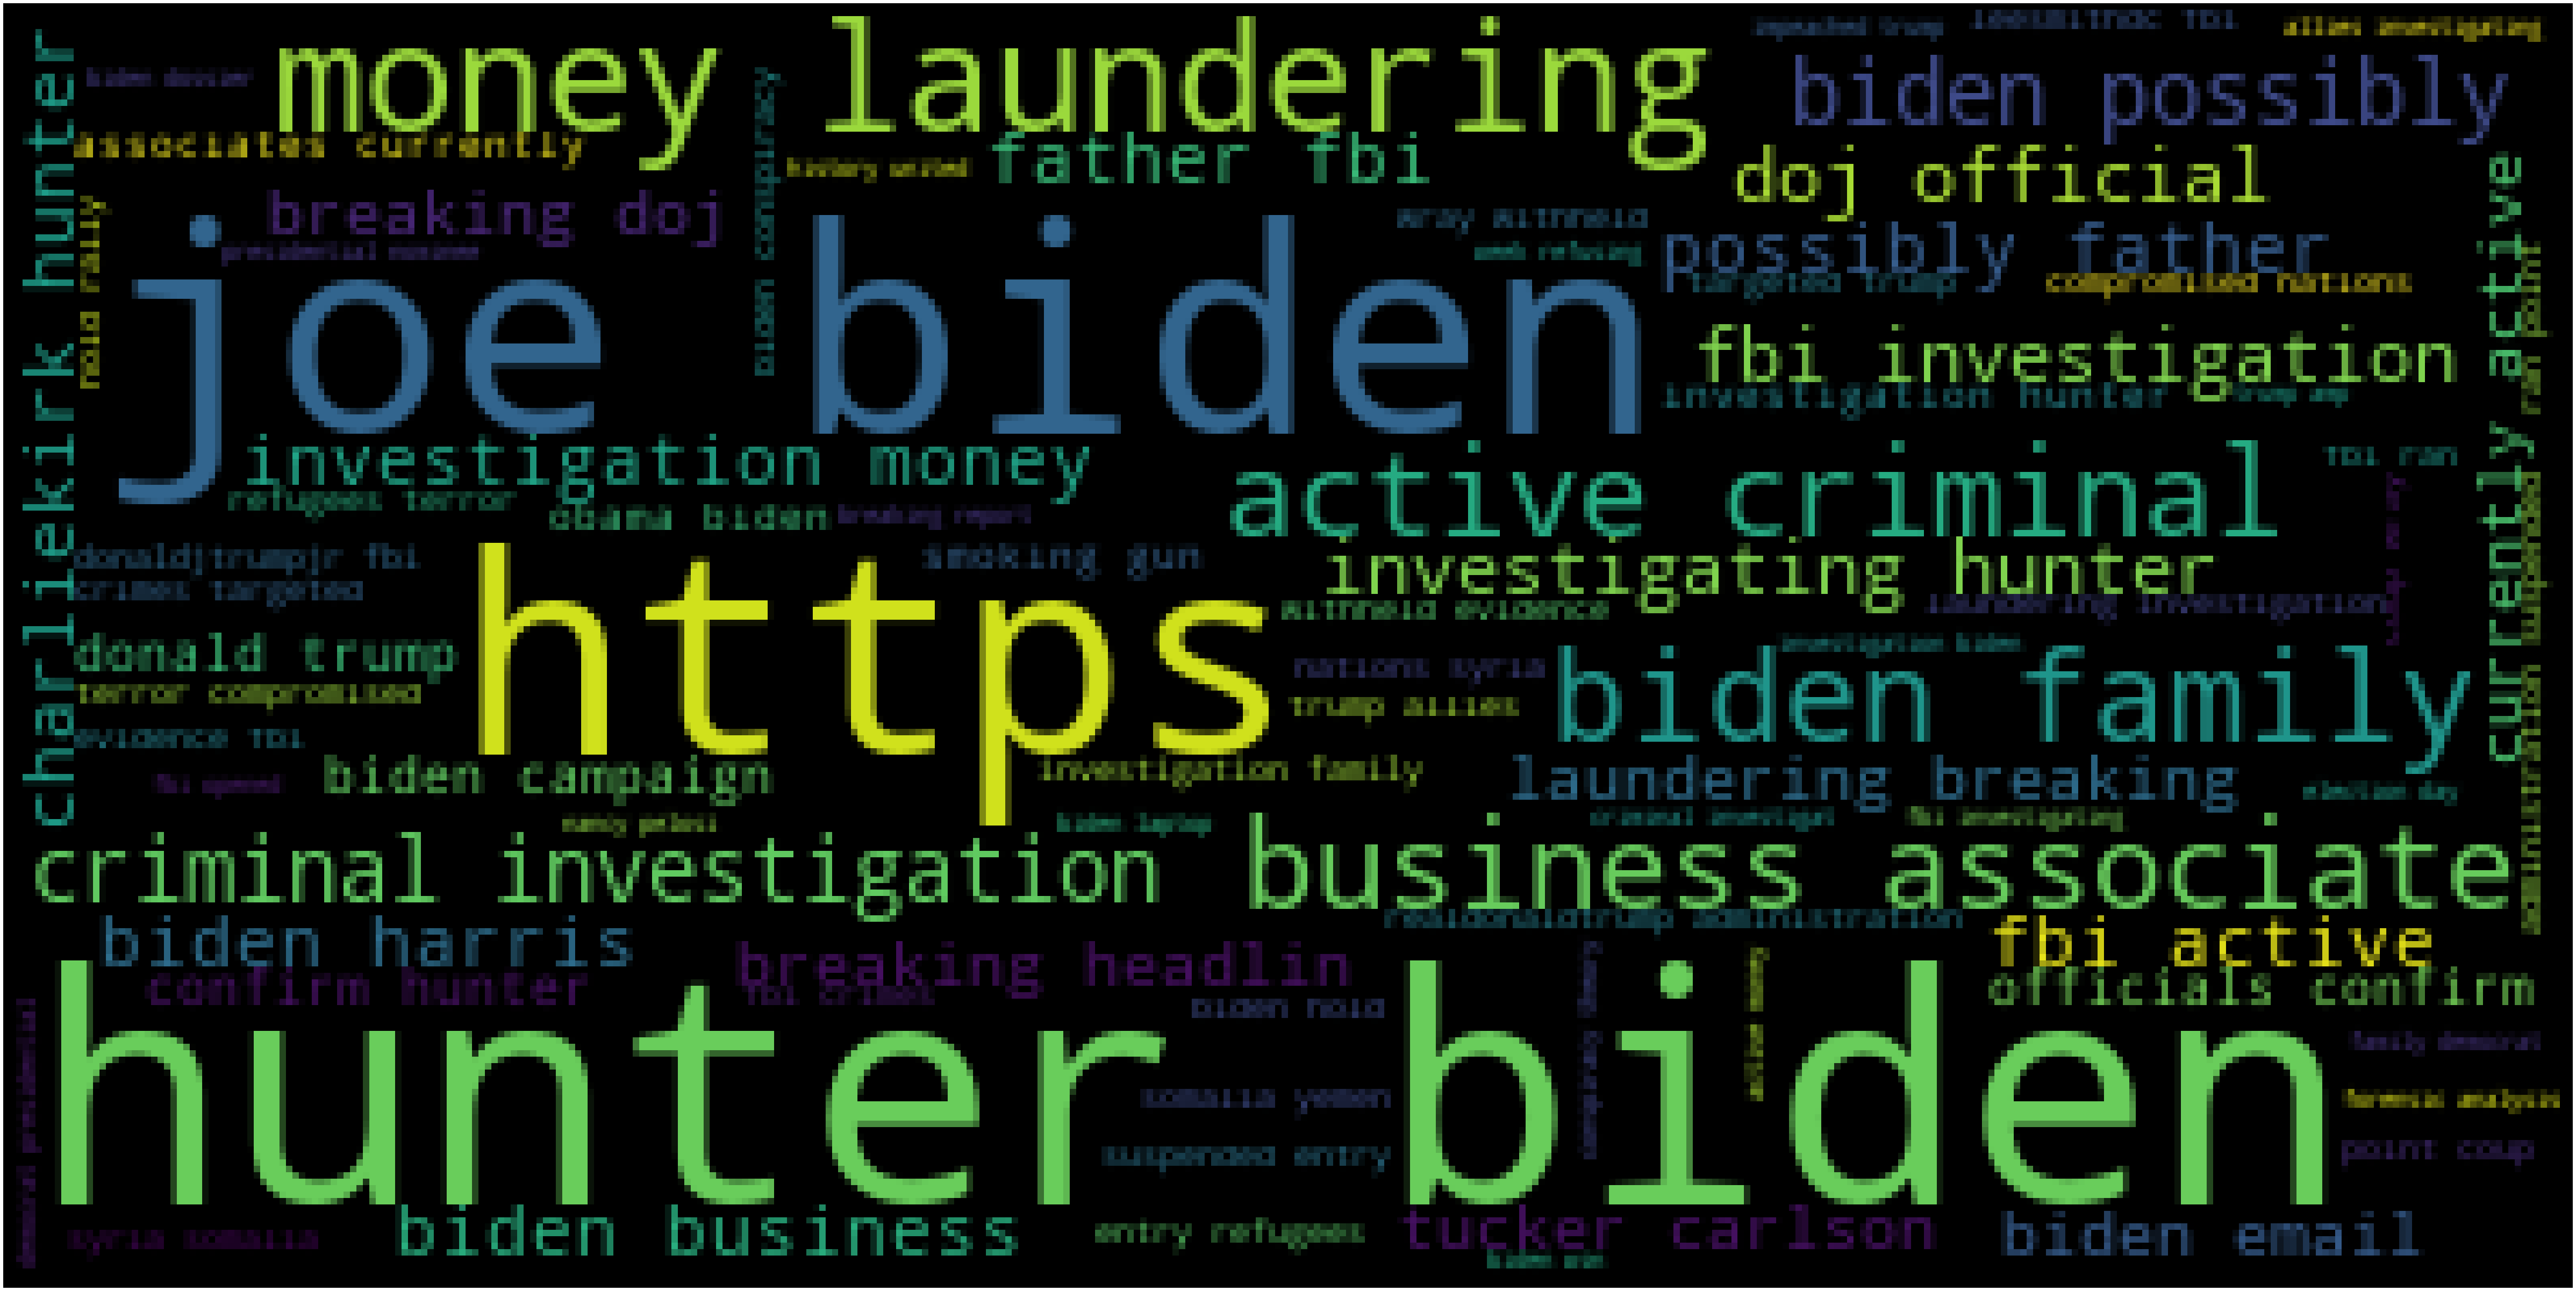

In [19]:
wc(cleaned_data_title,'black','Common Words' )

In [20]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")

<Figure size 720x720 with 0 Axes>

In [21]:
import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity

'51.85'